In [4]:
import pandas as pd
import os

def get_dataframe(dataset_path, encoding="utf-8"):
    try:
        # List all files in the dataset directory
        files = os.listdir(dataset_path)

        # Dictionary to store DataFrames
        dataframes = {}

        # Loop through each file
        for file in files:
            file_path = os.path.join(dataset_path, file)

            # Check for .csv or .txt files
            if file.endswith(".csv"):
                data = pd.read_csv(file_path, engine='c', encoding=encoding)
                dataframes[file] = data
            elif file.endswith(".txt"):
                data = pd.read_csv(file_path, delimiter='[|\t]', engine='python', header=None, encoding=encoding)
                dataframes[file] = data
        return dataframes
    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [5]:
kmrd_path = "../../kmrd-small"
dataframes = get_dataframe(kmrd_path)
print(f"{dataframes.keys()}")

dict_keys(['countries.csv', 'movies.txt', 'genres.csv', 'rates.csv', 'peoples.txt', 'castings.csv'])


In [6]:
# countries.csv 데이터프레임 불러오기
countries_df = dataframes['countries.csv']

movies_df = dataframes['movies.txt'].copy()
movies_df.columns = movies_df.iloc[0]  # 첫 번째 행을 열 이름으로 설정
movies_df = movies_df.iloc[1:]  # 첫 번째 행 제거
movies_df.reset_index(drop=True, inplace=True)

# 1. Title과 Title_eng의 결측치를 처리
# 둘 중 하나만 있는 경우, 없는 값을 다른 값으로 채움
movies_df.loc[movies_df['title'].isnull() & movies_df['title_eng'].notnull(), 'title'] = movies_df['title_eng']
movies_df.loc[movies_df['title_eng'].isnull() & movies_df['title'].notnull(), 'title_eng'] = movies_df['title']

# 둘 다 없는 경우 해당 행 제거
movies_df = movies_df.dropna(subset=['title', 'title_eng'])


# 2. Year 열의 결측치를 최빈값으로 채움
if movies_df['year'].isnull().sum() > 0:  # 결측치가 있는 경우
    most_frequent_year = movies_df['year'].mode()[0]  # 최빈값 계산
    movies_df['year'] = movies_df['year'].fillna(most_frequent_year)

# 3. Grade 열의 결측치를 'Unknown'으로 채움
movies_df['grade'] = movies_df['grade'].fillna('Unknown')

# 4. type 재설정
movies_df['movie'] = movies_df['movie'].astype(int)
movies_df['year'] = movies_df['year'].astype(int)

genres_df = dataframes['genres.csv']
rates_df = dataframes['rates.csv']

# Unix 타임스탬프를 datetime으로 변환
rates_df['time'] = pd.to_datetime(rates_df['time'], unit='s')

# peoples.txt 데이터프레임 불러오기
peoples_df = dataframes['peoples.txt'].copy()

# 첫 번째 행 제거 및 열 이름 설정
peoples_df.columns = peoples_df.iloc[0]  # 첫 번째 행을 열 이름으로 설정
peoples_df = peoples_df.iloc[1:]  # 첫 번째 행 제거

# 인덱스 재설정
peoples_df.reset_index(drop=True, inplace=True)

peoples_df['original'] = peoples_df['original'].fillna('Unknown')

# 4. type 재설정
peoples_df['people'] = peoples_df['people'].astype(int)

# castings.csv 데이터프레임 불러오기
castings_df = dataframes['castings.csv']

In [7]:
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # MacOS: 'AppleGothic', Windows: 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

### heatmap

- cmap : 색상 변경
- annot : True/False. 숫자로 된 상관걔수 값을 표시해준다. 기본값 False
- fmt : 숫자값의 포맷 변환. fmt=',1f'로 설정하면 소숫점 한 자리까지만 상관계숫값을 표시함
- cbar : True/False. 숫자값에 따른 색상 기준을 막대로 표시. 기본값 True
피처들끼리 상관도가 매우 높다면 상호 간의 높은 종속관계를 의심하여 특정 피처들을 제거하는 용도로 사용될 수 있다

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

def draw_heatmap(pivot_table, figsize=(12, 12), title=None, xlabel=None, ylabel=None, cmap='Blues'):
    """
    Draw a heatmap for the given pivot table.

    Args:
        pivot_table (pd.DataFrame): Precomputed pivot table or correlation matrix.
        figsize (tuple): Size of the figure. Default is (12, 12).
        title (str): Title for the heatmap. Default is None.
        xlabel (str): Label for the x-axis. Default is None.
        ylabel (str): Label for the y-axis. Default is None.
        cmap (str): Colormap for the heatmap. Default is 'Blues'.
    """
    plt.figure(figsize=figsize)

    # 히트맵 생성
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap=cmap, cbar=True, linewidths=0.5)

    # 축 및 제목 설정
    plt.xlabel(xlabel if xlabel else pivot_table.columns.name, fontsize=12)
    plt.ylabel(ylabel if ylabel else pivot_table.index.name, fontsize=12)
    plt.title(title if title else "Heatmap", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 영화의 장르간 상관 관계

In [9]:
genres_df.head(3)

,movie,genre
0,10001,드라마
1,10001,멜로/로맨스
2,10002,SF


In [10]:
rates_df.head(3)

,user,movie,rate,time
0,0,10003,7,2017-05-07 03:34:00
1,0,10004,7,2016-07-03 07:10:00
2,0,10018,9,2017-12-15 13:22:00


In [11]:
genre_per_movie = (
    rates_df.merge(genres_df, on='movie')
    .groupby(['movie', 'genre'], as_index=False)
    .agg(mean_rate=('rate', 'mean'))
)
genre_per_movie.head(3)

,movie,genre,mean_rate
0,10001,드라마,9.294360
1,10001,멜로/로맨스,9.294360
2,10002,SF,9.416778


In [12]:
# 피벗 테이블 생성
genre_pivot = genre_per_movie.pivot(index='movie', columns='genre', values='mean_rate').fillna(0)
genre_pivot.head()

genre,SF,가족,공포,느와르,다큐멘터리,드라마,멜로/로맨스,모험,뮤지컬,미스터리,범죄,서부,서사,스릴러,애니메이션,액션,에로,전쟁,코미디,판타지
movie,,,,,,,,,,,,,,,,,,,,
10001,0.000000,0.0,0.0,0.0,0.0,9.29436,9.29436,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
10002,9.416778,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,9.416778,0.000000
10003,9.270981,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,9.270981,0.000000
10004,9.120000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,9.12,0.0,0.0,0.0,0.000000,0.0,0.0,9.120000,9.120000
10005,9.048619,0.0,0.0,0.0,0.0,0.00000,0.00000,9.048619,0.0,0.0,0.0,0.00,0.0,0.0,0.0,9.048619,0.0,0.0,0.000000,9.048619


In [13]:
# 장르 간 상관관계 계산
genre_correlation = genre_pivot.corr()

# 상관관계 출력
genre_correlation.head()

genre,SF,가족,공포,느와르,다큐멘터리,드라마,멜로/로맨스,모험,뮤지컬,미스터리,범죄,서부,서사,스릴러,애니메이션,액션,에로,전쟁,코미디,판타지
genre,,,,,,,,,,,,,,,,,,,,
SF,1.000000,0.167381,0.136533,-0.035632,-0.011881,-0.239694,-0.126795,0.144064,-0.055104,0.051743,-0.064056,-0.010538,-0.011881,0.043462,0.037455,0.157641,-0.036252,-0.058858,0.064703,0.226839
가족,0.167381,1.000000,-0.031592,-0.026540,-0.008849,-0.110056,-0.029174,0.291625,0.159242,0.011470,-0.019971,-0.039364,-0.008849,-0.031311,0.322454,-0.056575,-0.027002,-0.059805,0.108525,0.210846
공포,0.136533,-0.031592,1.000000,-0.035439,-0.011817,-0.215505,-0.084787,-0.043824,-0.054807,0.182318,-0.080438,-0.052565,-0.011817,0.272205,-0.020323,-0.073910,-0.036057,-0.079860,-0.090979,0.149094
느와르,-0.035632,-0.026540,-0.035439,1.000000,-0.005144,0.022886,-0.030960,-0.048742,-0.023860,-0.021421,0.172689,-0.022884,-0.005144,0.006873,-0.008848,0.121983,-0.015697,0.025365,-0.063838,0.014108
다큐멘터리,-0.011881,-0.008849,-0.011817,-0.005144,1.000000,-0.046171,-0.020420,-0.016252,-0.007956,-0.007142,-0.015208,-0.007630,-0.001715,-0.019025,-0.002950,-0.025304,-0.005234,-0.011592,-0.021285,-0.011647


상관계수 : 공분산을 각각의 표준편차로 나눈 값
![image](cov.png)
공분산은 두 변수간의 관계를 측정하는 값이지만, 단위의 영향력을 제거하지 않고 계산한다.  
이에 비해 상관계수는 공분산을 각 데이터의 표준편차로 나누어 단위에 의존하지 않는 지표를 정의하였다. 
![image](corr.png)
- 상관계수는 두 속성의 값이 서로 상관없으면 0, 같은 방향으로 완전히 동일하면 1(양의 상관관계일수록 1에 가까워짐), 반대 방향으로 완전히 동일하면 -1(음의 상관관계일수록 -1에 가까워짐) 값으로 가진다.

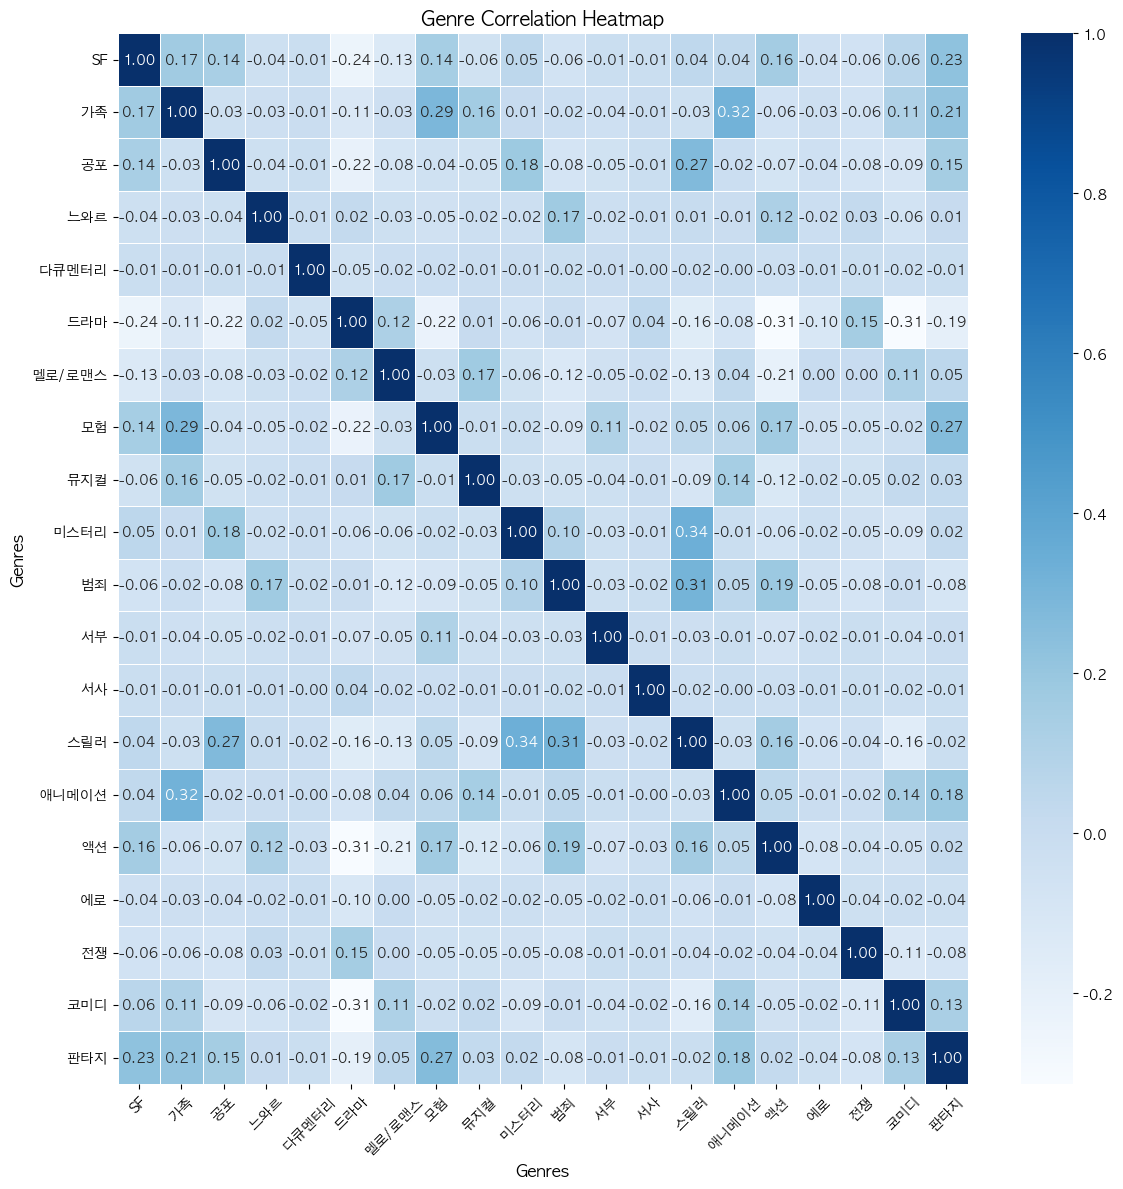

In [14]:
draw_heatmap(
    pivot_table=genre_correlation,
    title="Genre Correlation Heatmap",
    xlabel="Genres",
    ylabel="Genres"
)